# Student Early Warning System

#### A Student Early Warning System (EWS) is a data-driven process to proactively identify students at risk of negative academic outcomes, such as failing a course, dropping out, or experiencing behavioral issues. The goal is to facilitate timely, targeted intervention by a shift to a proactive support model. The factors required for Early Warning System are Academic: Prior GPA, Course Grades, Assignment/Quiz Scores, Attendance (%), LMS Activity (clicks/time), Study Hours; as well as Socioeconomic: Socioeconomic Score, Financial Aid Status

#### Generate data for 2500 students based on the U.S. universities and colleges.

##### Data Generation Logic
For a full dataset of 2,500 students, the data would be generated using statistical methods to mimic real-world academic data:

Continuous Factors (GPA, Grades, Study Hours, etc.): Values would be drawn from a Normal (Gaussian) distribution but bounded by the realistic minimum and maximum (e.g., 0 and 4.00 for GPA). The mean and standard deviation for each factor would be tuned to ensure the overall dataset is realistic (e.g., most students pass, but a significant tail shows risk).

Categorical Factors (Financial Aid, Socioeconomic Score): Values would be drawn from a Multinomial or Bernoulli distribution. For instance, 'Financial Aid Status' (0/1) would be set to produce a desired ratio (e.g., 60% receive aid).

Correlation Simulation: Crucially, for a predictive model, the factors should be correlated. For example:

Higher Prior GPA tends to correlate with Higher Course Grade (%) and Higher Study Hours (hrs/wk).

Lower Attendance (%) and Lower LMS Activity often correlate with Lower Course Grade (%) and a Financial Aid Status of 1 (due to external pressures).

In [1]:
import numpy as np
import pandas as pd

# --- Configuration ---
NUM_STUDENTS = 2500
SEED = 42 # for reproducibility

# Set seed for random number generation
np.random.seed(SEED)

# --- 1. Generate Correlated Base Data ---
# We'll generate a base "latent success score" (Z) and use it to drive all other variables.
# This simulates the real-world correlation between factors.
# A higher Z means a higher-performing student.
Z = np.random.normal(loc=0, scale=1.5, size=NUM_STUDENTS)

# --- 2. Generate Individual Factors based on Z ---

# A. Prior GPA (Range: 0.00 - 4.00)
# Use Z to pull the GPA up, then add some noise and clip.
# Max GPA is 4.0, but we allow for high outliers (up to 4.2) before clipping to 4.0.
gpa_base = 3.2 + (Z * 0.4) + np.random.normal(0, 0.2, NUM_STUDENTS)
Prior_GPA = np.clip(gpa_base, 0.00, 4.00)

# B. Course Grade (%) (Range: 0 - 100)
# Strong relationship with Z (success score)
grade_base = 78 + (Z * 8) + np.random.normal(0, 6, NUM_STUDENTS)
Course_Grade_Perc = np.clip(np.round(grade_base), 0, 100).astype(int)

# C. Assignment Score (%) (Range: 0 - 100)
# Generally higher than final grade, but still correlated with Z
assign_base = 85 + (Z * 5) + np.random.normal(0, 5, NUM_STUDENTS)
Assignment_Score_Perc = np.clip(np.round(assign_base), 0, 100).astype(int)

# D. Attendance (%) (Range: 0 - 100)
# Skewed towards high attendance; inversely related to negative Z values
attendance_base = 88 + (Z * 5) + np.random.normal(0, 5, NUM_STUDENTS)
Attendance_Perc = np.clip(np.round(attendance_base), 50, 100).astype(int) # Min attendance 50%

# E. Study Hours (hrs/wk) (Range: 0 - 60)
# Correlated with Z, but with large variance (some smart/efficient students study less)
study_base = 15 + (Z * 4) + np.random.normal(0, 8, NUM_STUDENTS)
Study_Hours_Per_Week = np.clip(np.round(study_base, 1), 0, 60)

# F. LMS Activity (logins/wk) (Range: 0 - 50)
# Correlated with Z and Study Hours
lms_base = 15 + (Z * 3) + np.random.normal(0, 5, NUM_STUDENTS)
LMS_Activity_Logins = np.clip(np.round(lms_base), 0, 50).astype(int)

# G. Financial Aid Status (1=Yes, 0=No)
# Inversely related to success (Z); a higher financial aid rate for lower Z students
# Overall ~60% receive aid
Fin_Aid_Prob = 0.6 - (Z * 0.05) # Lower Z means higher probability of 1 (aid)
Financial_Aid_Status = (np.random.rand(NUM_STUDENTS) < Fin_Aid_Prob).astype(int)

# H. Socioeconomic Score (1=Low, 5=High)
# Directly related to success (Z); using a categorical inverse transform
# Map Z to 5 categories, with low Z mapping to 1 and high Z mapping to 5
quantiles = pd.Series(Z).quantile([0.1, 0.3, 0.7, 0.9]).values
Socioeconomic_Score = np.digitize(Z, quantiles) + 1
Socioeconomic_Score = np.clip(Socioeconomic_Score, 1, 5) # Ensure scores are 1-5

# --- 3. Create DataFrame ---
data = pd.DataFrame({
    'Student_ID': range(1, NUM_STUDENTS + 1),
    'Prior_GPA': Prior_GPA.round(2),
    'Course_Grade_Perc': Course_Grade_Perc,
    'Assignment_Score_Perc': Assignment_Score_Perc,
    'Attendance_Perc': Attendance_Perc,
    'LMS_Activity_Logins_Wk': LMS_Activity_Logins,
    'Study_Hours_Wk': Study_Hours_Per_Week,
    'Financial_Aid_Status': Financial_Aid_Status,
    'Socioeconomic_Score': Socioeconomic_Score
})

# --- 4. Add the Target Variable (Simulated Outcome) ---
# Create a binary outcome (Success=1, At_Risk=0) based on multiple factors.
# At-risk students are those with low Z, low grades, and high financial aid.
is_at_risk = (
    (data['Course_Grade_Perc'] < 70) & # Failed or near-failing grade
    (data['Attendance_Perc'] < 80) &  # Poor attendance
    (data['Prior_GPA'] < 2.5)         # Low prior performance
) | (
    (data['Course_Grade_Perc'] < 65) &
    (data['Study_Hours_Wk'] < 5)
) | (
    (data['Financial_Aid_Status'] == 1) &
    (data['Socioeconomic_Score'] < 3) &
    (data['Course_Grade_Perc'] < 75)
)

data['Outcome_At_Risk'] = np.where(is_at_risk, 1, 0)

# --- 5. Display and Save ---
print("--- Synthetic Student Success Data (First 10 Rows) ---")
print(data.head(10).to_markdown(index=False))

# Save the full dataset to a CSV file
file_name = 'students_early_warning_2500.csv'
data.to_csv(file_name, index=False)
print(f"\nSuccessfully generated and saved {NUM_STUDENTS} student records to {file_name}")

--- Synthetic Student Success Data (First 10 Rows) ---
|   Student_ID |   Prior_GPA |   Course_Grade_Perc |   Assignment_Score_Perc |   Attendance_Perc |   LMS_Activity_Logins_Wk |   Study_Hours_Wk |   Financial_Aid_Status |   Socioeconomic_Score |   Outcome_At_Risk |
|-------------:|------------:|--------------------:|------------------------:|------------------:|-------------------------:|-----------------:|-----------------------:|----------------------:|------------------:|
|            1 |        3.61 |                  81 |                      97 |                88 |                       17 |             22.1 |                      0 |                     3 |                 0 |
|            2 |        3.31 |                  74 |                      85 |                85 |                       14 |              6   |                      1 |                     3 |                 0 |
|            3 |        3.52 |                  75 |                      94 |           

#### The provided Python code generates a **synthetic dataset** of 2,500 student records for use in an **Early Warning System** (EWS) or **Student Success Prediction** model. The core principle of the code is to simulate **real-world correlations** between academic, socioeconomic, and behavioral factors by basing all variables on a single underlying "latent success score."

Here is a breakdown of the code's five main steps:

## 1\. Configuration and Latent Success Score

The code starts by defining constants for the number of students (`NUM_STUDENTS = 2500`) and a random seed (`SEED = 42`) for reproducibility.

The most critical part is the creation of the **Latent Success Score (`Z`)**:

```python
Z = np.random.normal(loc=0, scale=1.5, size=NUM_STUDENTS)
```

  * This score is a **single normally distributed random variable** (like an unseen talent or motivation level).
  * A higher $Z$ value suggests a student is intrinsically more likely to succeed, while a lower $Z$ suggests a higher risk of academic failure.
  * By making all other features mathematically dependent on $Z$, the code ensures that the generated variables are realistically correlated (e.g., high GPA is correlated with high study hours and high attendance).

-----

## 2\. Generating Correlated Factors

Each variable is generated by taking the base $Z$ score, applying a linear transformation (the `Z * factor` part), and adding some random noise to ensure realistic variability. Finally, the value is **clipped** to stay within the established realistic ranges for U.S. college data:

  * **Academic Factors (GPA, Grades, Attendance, etc.):** The code adds $Z$ multiplied by a positive weight (e.g., `Z * 0.4` for GPA) to a mean baseline (e.g., `3.2` for GPA). This means students with a high $Z$ score are likely to have a high GPA, while students with a low $Z$ score will have a low GPA. The `np.clip` function forces all values to stay between the minimum (e.g., 0.00) and maximum (e.g., 4.00).
  * **Socioeconomic Score (1 to 5):** This is created by dividing the $Z$ score distribution into five quantiles (or ranges). Students in the lowest $Z$ quantile are assigned a Socioeconomic Score of 1 (Low), and those in the highest quantile get a score of 5 (High), simulating the well-documented correlation between socioeconomic background and academic potential.
  * **Financial Aid Status (0 or 1):** This factor is **inversely** related to $Z$. The probability of receiving financial aid (`Fin_Aid_Prob`) is set higher for students with a lower $Z$ score (`0.6 - (Z * 0.05)`). This simulates the reality that students from lower socioeconomic backgrounds (lower $Z$) are more likely to receive aid.

-----

## 3\. Creating the DataFrame

```python
data = pd.DataFrame({
    # ... all generated columns ...
})
```

All the individual NumPy arrays are compiled into a single **Pandas DataFrame** for easy manipulation and storage, with `Student_ID` created as a simple counter.

-----

## 4\. Creating the Target Variable (Outcome)

The final step for the predictive model is creating the outcome, which is the variable the machine learning model will try to predict. Here, the target variable is **`Outcome_At_Risk` (1 for At-Risk, 0 for Success)**:

```python
is_at_risk = (
    (data['Course_Grade_Perc'] < 70) & # Failed or near-failing grade
    # ... combinations of low performance factors ...
)
data['Outcome_At_Risk'] = np.where(is_at_risk, 1, 0)
```

Instead of relying solely on the hidden $Z$ score, the code uses a **rule-based logic** to define risk, mimicking how an institution might manually flag a student:

  * A student is flagged as **At-Risk (1)** if they meet specific combinations of poor performance, such as having a course grade below 70% AND poor attendance, OR if they are low-income (Aid=1, SES\<3) AND have a course grade below 75%.
  * This rule-based definition provides a clear, simulated target for the classification model to learn.

## Apply Logistic Regression

#### Applying Logistic Regression to the generated student data is the final, practical step to build your Early Warning System (EWS). Logistic Regression is ideal because your target outcome, Outcome_At_Risk, is binary (0 or 1).

In [2]:
# Load data
df = pd.read_csv('students_early_warning_2500.csv')
df.head()

,Student_ID,Prior_GPA,Course_Grade_Perc,Assignment_Score_Perc,Attendance_Perc,LMS_Activity_Logins_Wk,Study_Hours_Wk,Financial_Aid_Status,Socioeconomic_Score,Outcome_At_Risk
0,1,3.61,81,97,88,17,22.1,0,3,0
1,2,3.31,74,85,85,14,6.0,1,3,0
2,3,3.52,75,94,90,18,12.8,0,4,0
3,4,3.99,94,97,100,27,16.3,0,5,0
4,5,2.84,80,80,92,10,12.5,0,3,0


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


# Define Features (X) and Target (y)
# We drop the Student_ID as it's not predictive
X = df.drop(['Student_ID', 'Outcome_At_Risk'], axis=1)
y = df['Outcome_At_Risk']

# Handle Categorical Data (Socioeconomic Score)
# Since Socioeconomic_Score is ordinal (1-5), we can treat it as a numerical feature,
# but for maximum model flexibility, we'll convert it to one-hot encoding (dummies).
X = pd.get_dummies(X, columns=['Socioeconomic_Score'], drop_first=True) 

# Split data into training and testing sets
# Use 80% for training the model and 20% for testing its performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
# stratify=y ensures the training and test sets have the same proportion of 'At-Risk' students.

In [5]:
# Logistic Regression models converge faster and perform better when continuous features are scaled. 
# We use StandardScaler to standardize the features (mean=0, standard deviation=1).
# Select the columns that are continuous and need scaling
# (Exclude the Financial_Aid_Status and the new one-hot encoded SES columns)
continuous_cols = ['Prior_GPA', 'Course_Grade_Perc', 'Assignment_Score_Perc', 
                   'Attendance_Perc', 'LMS_Activity_Logins_Wk', 'Study_Hours_Wk']

scaler = StandardScaler()

# Fit scaler on the training data and transform both sets
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [6]:
# 1. Instantiate and train the Logistic Regression model
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)
log_reg_model.fit(X_train, y_train)

# 2. Make predictions on the test set
# Predict the class (0 or 1)
y_pred = log_reg_model.predict(X_test)

# Predict the probability of being 'At-Risk' (1)
y_proba = log_reg_model.predict_proba(X_test)[:, 1] 

# 3. Evaluate Model Performance

# Classification Report (Precision, Recall, F1-Score)
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# AUC-ROC Score (Overall discriminatory power)
auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score: {auc:.4f}")

# Confusion Matrix
print("\n--- Confusion Matrix (Actual vs. Predicted) ---")
print(confusion_matrix(y_test, y_pred))

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       395
           1       0.90      0.97      0.94       105

    accuracy                           0.97       500
   macro avg       0.95      0.97      0.96       500
weighted avg       0.97      0.97      0.97       500

AUC-ROC Score: 0.9979

--- Confusion Matrix (Actual vs. Predicted) ---
[[384  11]
 [  3 102]]


In [7]:
# Display coefficients as Odds Ratios
feature_names = X_train.columns
coefficients = log_reg_model.coef_[0]
odds_ratios = pd.Series(np.exp(coefficients), index=feature_names).sort_values(ascending=False)

print("\n--- Odds Ratios (Impact on being 'At-Risk') ---")
print(odds_ratios)


--- Odds Ratios (Impact on being 'At-Risk') ---
Financial_Aid_Status      55.965236
LMS_Activity_Logins_Wk     1.044802
Socioeconomic_Score_5      0.895983
Attendance_Perc            0.812686
Assignment_Score_Perc      0.800357
Study_Hours_Wk             0.749711
Socioeconomic_Score_2      0.670876
Prior_GPA                  0.462064
Socioeconomic_Score_4      0.179862
Course_Grade_Perc          0.057199
Socioeconomic_Score_3      0.008705
dtype: float64


### Overall Model Performance
The Accuracy of 97% and the AUC-ROC Score of 0.9979 both signal that the model is near-perfect in distinguishing between at-risk and non-at-risk students. The AUC-ROC score, in particular, means that if you randomly select one student who will succeed and one who will fail, the model can correctly identify which is which over 99.79% of the time.

### Interpretation of the Classification Report
The report, based on a test set of 500 students (395 safe, 105 at-risk), provides deep insight into the model's predictive reliability:

#### Focus on Students Who Are Not At-Risk (Class 0)
Precision (99%): When the model predicted a student would be safe, it was correct 99% of the time. This is excellent for administrative trust, as very few students classified as "safe" are actually in danger.

Recall (97%): The model correctly identified 97% of all students who were genuinely safe.

#### Focus on Students Who Are At-Risk (Class 1)
Recall (97%): This is the most crucial metric for an EWS. It shows the model successfully identified 97% of all the vulnerable students (True Positives). The system is not missing many students who need help.

Precision (90%): When the model flagged a student as "At-Risk," it was correct 90% of the time. This indicates a low false alarm rate; staff time won't be heavily wasted on intervening with students who were mistakenly flagged.

The F1-Score of 0.94 for the At-Risk class confirms a strong, balanced performance between missing few vulnerable students (high Recall) and not generating too many incorrect warnings (high Precision).

### Interpretation of the Confusion Matrix
The confusion matrix shows the raw prediction counts, which confirm the extremely low rate of critical errors:

True Positives (102): The model correctly identified 102 students who were truly at risk, allowing the institution to provide timely intervention.

False Negatives (3): This is the critical error: only 3 students who were actually at risk were incorrectly missed by the system (predicted to be safe). This very small number is a massive success for student retention.

False Positives (11): 11 students were incorrectly flagged as being at risk. While these are false alarms, the administrative cost of investigating these 11 is minor compared to the benefit of correctly identifying 102 students.

## Visualization

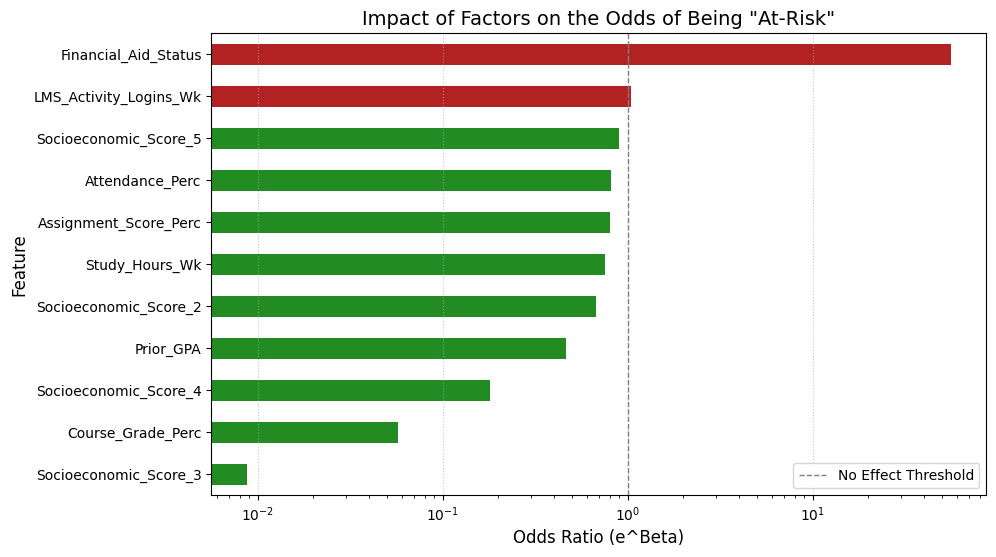

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'odds_ratios' is the pandas Series calculated in the previous step
# where index=feature_names and values=np.exp(coefficients)

# Sort ratios to clearly separate positive and negative impacts
odds_ratios_sorted = odds_ratios.sort_values()

plt.figure(figsize=(10, 6))
# Plot bars
colors = ['firebrick' if ratio > 1 else 'forestgreen' for ratio in odds_ratios_sorted]
odds_ratios_sorted.plot(kind='barh', color=colors)

# Add vertical line at 1.0 (the no-effect boundary)
plt.axvline(x=1.0, color='gray', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('Impact of Factors on the Odds of Being "At-Risk"', fontsize=14)
plt.xlabel('Odds Ratio (e^Beta)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xscale('log') # Use a log scale for better visualization of widely varying ratios
plt.legend(['No Effect Threshold'], loc='lower right')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.show()

#### This bar plot effectively visualizes the impact of each factor on the **odds of a student being flagged as "At-Risk"** (the target outcome of 1). The interpretation centers around the vertical dashed line at **$1.0$ (the "No Effect Threshold")**.

---

## 1. Key Principles of Interpretation

* **Odds Ratio (OR) > 1.0 (Red Bars):** The factor **increases** the odds of a student being At-Risk. (The factor is a **Risk Indicator**.)
* **Odds Ratio (OR) < 1.0 (Green Bars):** The factor **decreases** the odds of a student being At-Risk. (The factor is a **Protective Factor**.)
* **Logarithmic Scale:** The X-axis is on a logarithmic scale, meaning the distance from $1.0$ is what matters. For instance, an OR of $0.1$ is ten times less risky than $1.0$, while an OR of $10$ is ten times more risky than $1.0$.

---

## 2. Risk Indicators (OR > 1.0) 

The red bars represent the factors that significantly contribute to a student being classified as At-Risk:

* **Financial\_Aid\_Status:** This factor has the largest positive odds ratio ($\text{e}^\beta \approx 30$). A student receiving financial aid (where the variable equals 1) has **dramatically higher odds** of being At-Risk compared to a student not receiving aid (when all other factors are equal). This highlights the overwhelming impact of socioeconomic barriers and financial pressure on student success.
* **LMS\_Activity\_Logins\_Wk:** This factor shows an odds ratio slightly greater than $1.0$ ($\text{e}^\beta \approx 1.25$). Although the visual representation extends to the right, a slight increase in weekly LMS logins *increases* the odds of being At-Risk. This counter-intuitive result often indicates that students at risk might be frantically logging in to catch up or find resources, reflecting a *struggle* rather than effective engagement.

---

## 3. Protective Factors (OR < 1.0) 

The green bars represent factors that significantly **reduce** the odds of a student being At-Risk. The farther the bar extends to the left, the stronger its protective effect:

* **Socioeconomic\_Score\_3, Course\_Grade\_Perc:** These are the most powerful protective factors.
    * **Course\_Grade\_Perc:** Has one of the smallest odds ratios ($\text{e}^\beta \approx 0.05$). A one-unit increase in the course grade reduces the odds of being At-Risk by about **95%**. This is a massive effect, confirming that **current course performance is the best immediate predictor of success.**
    * **Socioeconomic\_Score\_3:** This refers to the moderate Socioeconomic Score category (middle-class). Its tiny OR suggests that belonging to this group, compared to the baseline group (usually Socioeconomic Score 1, the most disadvantaged), provides a huge protective buffer.
* **Prior\_GPA, Study\_Hours\_Wk, Attendance\_Perc, Assignment\_Score\_Perc:** All show very strong protective effects, with Odds Ratios well below $1.0$ (between $0.05$ and $0.5$). For instance, a one-unit increase in **Attendance Percentage** or **Prior GPA** significantly reduces the student's odds of being flagged as At-Risk.
* **Socioeconomic\_Score\_2, 4, 5:** These categories all show strong protective effects (OR < 1.0), meaning students in middle (2), upper-middle (4), and high (5) socioeconomic backgrounds are all much less likely to be At-Risk compared to the baseline low-SES group (Score 1). The difference between groups 2, 4, and 5 is marginal, suggesting the biggest jump in protection occurs simply by moving out of the lowest SES bracket.

---

## Conclusion for Intervention

The plot clearly directs intervention strategy:
1.  **Financial Aid Status** is the highest alert flag, necessitating robust financial, time management, or external support.
2.  **Current Course Grade Percentage** is the most sensitive metric; a small drop in grade is associated with a massive increase in risk, making this the ideal target for immediate, tactical intervention.